In [857]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import mstats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [858]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix, classification_report

In [859]:
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [860]:
customers.head()

,customer_id,join_date,last_purchase_date,age,gender,location
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort


In [861]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [862]:
engagement.head()

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
0,1,10,15,1
1,2,285,49,51
2,3,192,73,25
3,4,110,30,17
4,5,161,2,7


In [863]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB


In [864]:
# marketing table check
# this table is at a CAMPAIGN ID level. It has 25,200 rows which means each customer will have MULTIPLE marketing offers
# this table captures if the customer responded to the offer or not
# Consider aggregating this table at a customer level (e.g., you could aggregate based on number of campaigns they responded YES to, or the most common campaign they responded to, etc.)
marketing.head()

,campaign_id,customer_id,response,promotion_type,campaign_date
0,1,1,No,Buy One Get One,2024-02-29
1,2,1,No,Discount,2024-01-24
2,3,1,No,Free Shipping,2024-03-05
3,4,1,Yes,Buy One Get One,2024-01-10
4,5,2,Yes,Free Shipping,2022-07-08


In [865]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


In [866]:
# you will use this table to calculate LTV. Hint: you should SUM all transaction amounts PER customer, to calculate total LTV
# you can use the other features (like last transaction date) to calculate their customer age (e.g., time between join date and last transaction date)
# you could also consider feature engineering a favourite category for example
# consider using RFM framework to assess the recency, frequency, or monetary value of transactions to create segments
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics


In [867]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      129545 non-null  int64  
 1   customer_id         129545 non-null  int64  
 2   transaction_date    129545 non-null  object 
 3   transaction_amount  129545 non-null  float64
 4   product_category    129545 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB


In [868]:
marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()

In [869]:
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

In [870]:
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

In [871]:
joint_data = customers.join(engagement).join(transactions_agg).join(marketing_agg)

In [872]:
joint_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   join_date                10000 non-null  object 
 1   last_purchase_date       10000 non-null  object 
 2   age                      8991 non-null   float64
 3   gender                   9467 non-null   object 
 4   location                 10000 non-null  object 
 5   number_of_site_visits    10000 non-null  int64  
 6   number_of_emails_opened  10000 non-null  int64  
 7   number_of_clicks         10000 non-null  int64  
 8   transaction_id           10000 non-null  int64  
 9   transaction_amount       10000 non-null  float64
 10  campaign_id              7665 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 937.5+ KB


In [873]:
# Handle missing values
joint_data['age'].fillna(joint_data['age'].median(), inplace=True)
joint_data['gender'].fillna('Unknown', inplace=True)
joint_data['location'].fillna('Unknown', inplace=True)
joint_data['last_purchase_date'].fillna(joint_data['join_date'], inplace=True)
joint_data.fillna(0, inplace=True)

/var/folders/ft/gq7wv6zs1slgbv35cnp736j00000gp/T/ipykernel_3860/310510056.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joint_data['age'].fillna(joint_data['age'].median(), inplace=True)
/var/folders/ft/gq7wv6zs1slgbv35cnp736j00000gp/T/ipykernel_3860/310510056.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

In [874]:
nan_check = joint_data.isnull().sum()
print(nan_check)

join_date                  0
last_purchase_date         0
age                        0
gender                     0
location                   0
number_of_site_visits      0
number_of_emails_opened    0
number_of_clicks           0
transaction_id             0
transaction_amount         0
campaign_id                0
dtype: int64


In [875]:
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,44.0,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,44.0,Unknown,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,44.0,Male,East Matthewfort,161,2,7,24,15524.55,0.0


Summary Statistics:
                 age  number_of_site_visits  number_of_emails_opened  \
count  10000.000000           10000.000000             10000.000000   
mean      43.521200             100.111900                39.862100   
std       14.313443             118.625052                46.511719   
min       18.000000               1.000000                 1.000000   
25%       32.000000              15.000000                 6.000000   
50%       44.000000              53.000000                22.000000   
75%       55.000000             141.000000                57.000000   
max       69.000000             711.000000               303.000000   

       number_of_clicks  transaction_id  transaction_amount   campaign_id  
count      10000.000000    10000.000000        10000.000000  10000.000000  
mean          19.725300       12.954500         7737.562981      1.257800  
std           22.975083        7.191203         4628.799469      0.971511  
min            1.000000        1.00

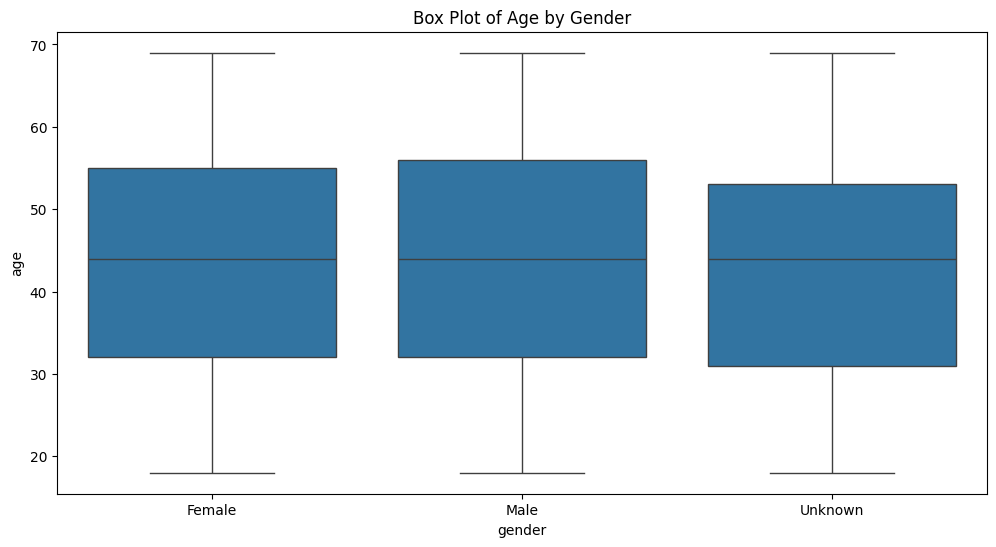

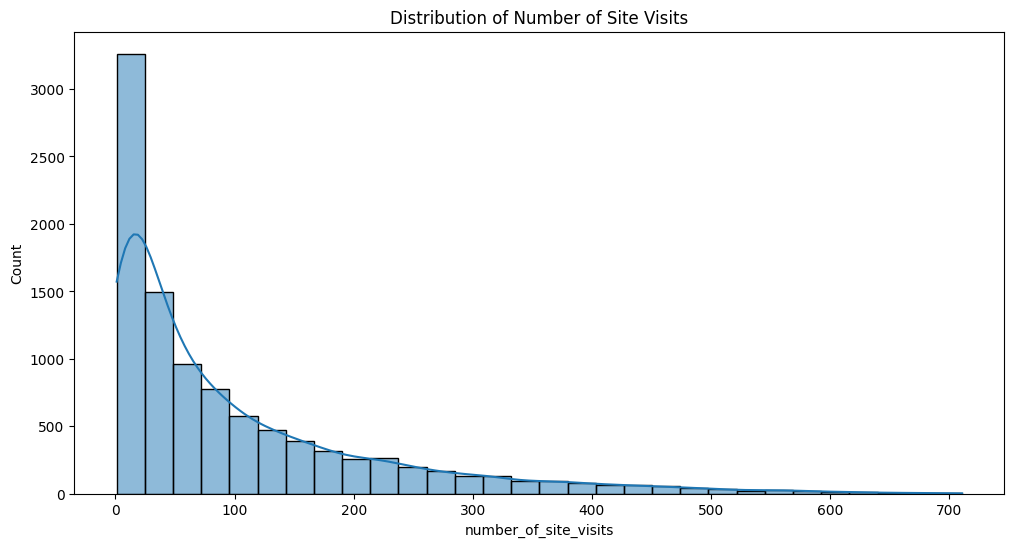

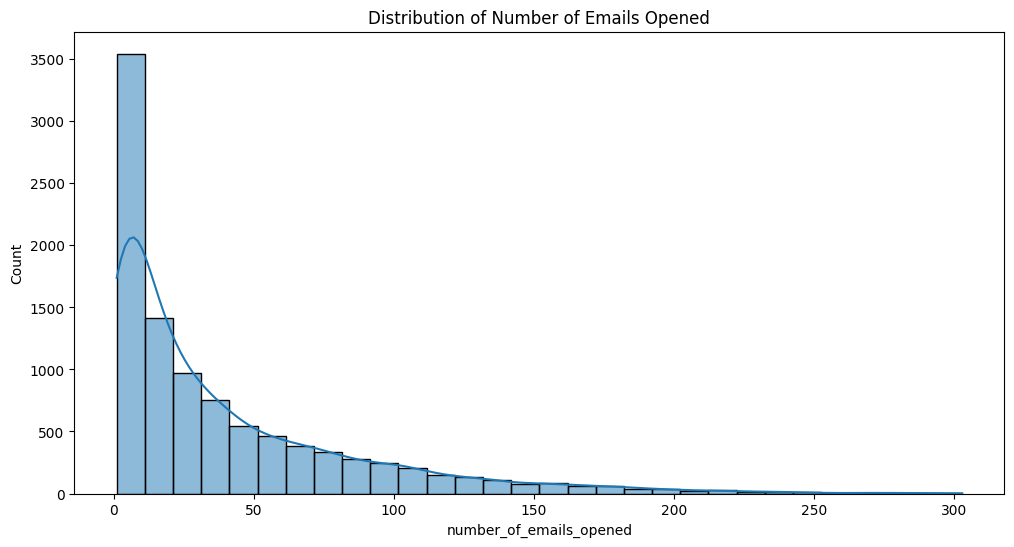

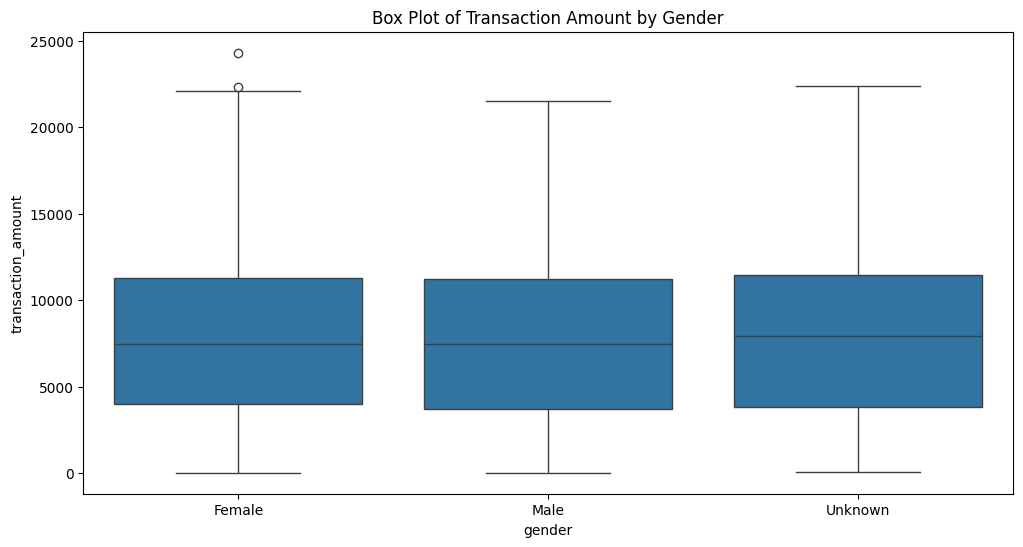

In [876]:
# Summary Statistics
print("Summary Statistics:\n", joint_data.describe())

# Distribution Plots (Histograms)
# Box Plot for Age by Gender
plt.figure(figsize=(12, 6))
sns.boxplot(x='gender', y='age', data=joint_data)
plt.title('Box Plot of Age by Gender')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(joint_data['number_of_site_visits'], bins=30, kde=True)
plt.title('Distribution of Number of Site Visits')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(joint_data['number_of_emails_opened'], bins=30, kde=True)
plt.title('Distribution of Number of Emails Opened')
plt.show()

# Box Plots
plt.figure(figsize=(12, 6))
sns.boxplot(x='gender', y='transaction_amount', data=joint_data)
plt.title('Box Plot of Transaction Amount by Gender')
plt.show()

In [877]:
joint_data['join_date'] = pd.to_datetime(joint_data['join_date'])
joint_data['last_purchase_date'] = pd.to_datetime(joint_data['last_purchase_date'])

In [878]:
# Calculate Recency: days since the last purchase
current_date = datetime.now()
joint_data['recency'] = (current_date - joint_data['last_purchase_date']).dt.days


In [879]:
# Calculate Frequency: number of purchases
joint_data['frequency'] = joint_data['transaction_id']

In [880]:
# Calculate Monetary: total spend
joint_data['monetary'] = joint_data['transaction_amount']

In [881]:
# Calculate Customer Age (time since joining)
joint_data['join_date'] = pd.to_datetime(joint_data['join_date'])
joint_data['customer_age'] = (current_date - joint_data['join_date']).dt.days

In [882]:
# Calculate Average Transaction Amount
joint_data['avg_transaction_amount'] = joint_data['monetary'] / joint_data['frequency']

In [883]:
# Calculate Engagement Level
joint_data['engagement_level'] = joint_data[['number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks']].sum(axis=1)

In [884]:
# Create interaction features
joint_data['recency_customer_age_ratio'] = joint_data['recency'] / joint_data['customer_age']
joint_data['avg_spend_per_visit'] = joint_data['monetary'] / joint_data['number_of_site_visits']

In [885]:
# Assuming a customer lifespan of 1 year for simplification (this should be adjusted based on business knowledge)
joint_data['customer_lifespan'] = joint_data['customer_age'].mean()/30

# Calculate CLV using the provided formula
joint_data['clv'] = joint_data['avg_transaction_amount'] * joint_data['frequency'] * joint_data['customer_lifespan']

In [886]:
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,recency,frequency,monetary,customer_age,avg_transaction_amount,engagement_level,recency_customer_age_ratio,avg_spend_per_visit,customer_lifespan,clv
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,122,6,3509.48,240,584.913333,26,0.508333,350.948000,28.353513,99506.087973
2,2021-09-08,2023-10-25,44.0,Male,Hillville,285,49,51,9,6081.32,...,266,9,6081.32,1043,675.702222,385,0.255034,21.337965,28.353513,172426.787704
3,2021-06-01,2022-11-27,44.0,Unknown,North Latoyatown,192,73,25,6,1454.87,...,598,6,1454.87,1142,242.478333,290,0.523643,7.577448,28.353513,41250.675943
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,685,20,7874.68,928,393.734000,157,0.738147,71.588000,28.353513,223274.844376
5,2022-01-24,2023-06-02,44.0,Male,East Matthewfort,161,2,7,24,15524.55,...,411,24,15524.55,905,646.856250,170,0.454144,96.425776,28.353513,440175.535419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,...,339,10,5498.20,579,549.820000,182,0.585492,46.203361,28.353513,155893.287009
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,...,539,12,5848.30,739,487.358333,50,0.729364,1949.433333,28.353513,165819.852027
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,...,169,3,3503.13,304,1167.710000,75,0.555921,66.096792,28.353513,99326.043163


In [887]:
joint_data['gender'] = joint_data['gender'].replace({'Male': -1, 'Female': 1, 'Unknown': 0})

/var/folders/ft/gq7wv6zs1slgbv35cnp736j00000gp/T/ipykernel_3860/121067543.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  joint_data['gender'] = joint_data['gender'].replace({'Male': -1, 'Female': 1, 'Unknown': 0})


In [888]:
# Drop columns that are not needed anymore
joint_data.drop(columns=['transaction_id', 'transaction_amount', 'last_purchase_date', 'join_date', 'location'], inplace=True)

In [889]:
clv_threshold = joint_data['clv'].median()
joint_data['high_value_customer'] = (joint_data['clv'] > clv_threshold).astype(int)

In [890]:
X= joint_data[['number_of_clicks','age', 'number_of_emails_opened','avg_transaction_amount', 'recency','gender','customer_age','engagement_level', 'avg_spend_per_visit']]
y= joint_data['high_value_customer']

In [891]:
print(joint_data.columns)

Index(['age', 'gender', 'number_of_site_visits', 'number_of_emails_opened',
       'number_of_clicks', 'campaign_id', 'recency', 'frequency', 'monetary',
       'customer_age', 'avg_transaction_amount', 'engagement_level',
       'recency_customer_age_ratio', 'avg_spend_per_visit',
       'customer_lifespan', 'clv', 'high_value_customer'],
      dtype='object')


In [892]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [893]:
# Display the shapes of the train and test sets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (8000, 9)
Test set shape: (2000, 9)


In [894]:
# Train a Logistic Regression model
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [895]:
# Predict on the test set
y_pred_logistic = logistic_reg.predict(X_test)

In [896]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_logistic)
precision = precision_score(y_test, y_pred_logistic)
recall = recall_score(y_test, y_pred_logistic)
f1 = f1_score(y_test, y_pred_logistic)
conf_matrix = confusion_matrix(y_test, y_pred_logistic)
print(f'Logistic Regression - Accuracy: {accuracy}')
print(f'Logistic Regression - Precision: {precision}')
print(f'Logistic Regression - Recall: {recall}')
print(f'Logistic Regression - F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

Logistic Regression - Accuracy: 0.5775
Logistic Regression - Precision: 0.5922693266832918
Logistic Regression - Recall: 0.4783484390735146
Logistic Regression - F1 Score: 0.5292479108635098
Confusion Matrix:
[[680 327]
 [518 475]]


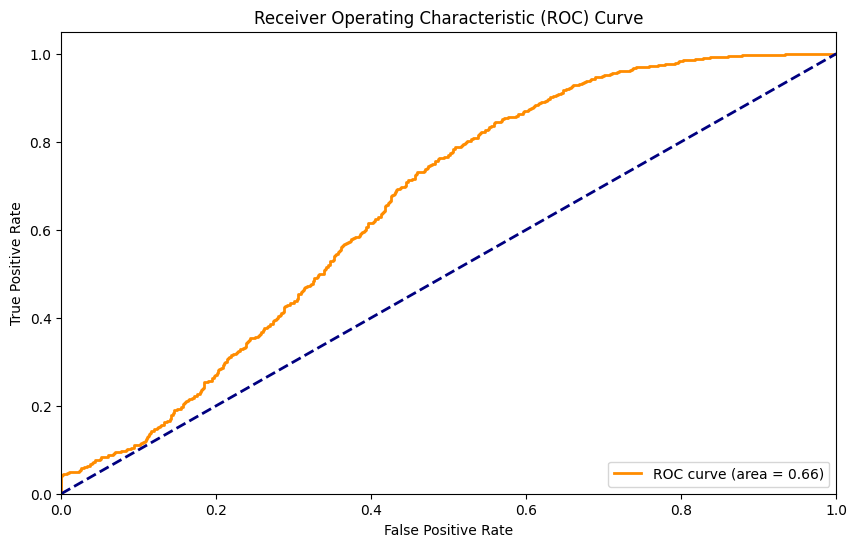

In [897]:
# Predict the probabilities for the positive class
y_prob_logistic = logistic_reg.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob_logistic)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [898]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.68      0.62      1007
           1       0.59      0.48      0.53       993

    accuracy                           0.58      2000
   macro avg       0.58      0.58      0.57      2000
weighted avg       0.58      0.58      0.57      2000



In [899]:
# Train a Linear Regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)


LinearRegression()

In [900]:
# Predict on the test set
y_pred_linear = linear_reg.predict(X_test)


<Axes: >

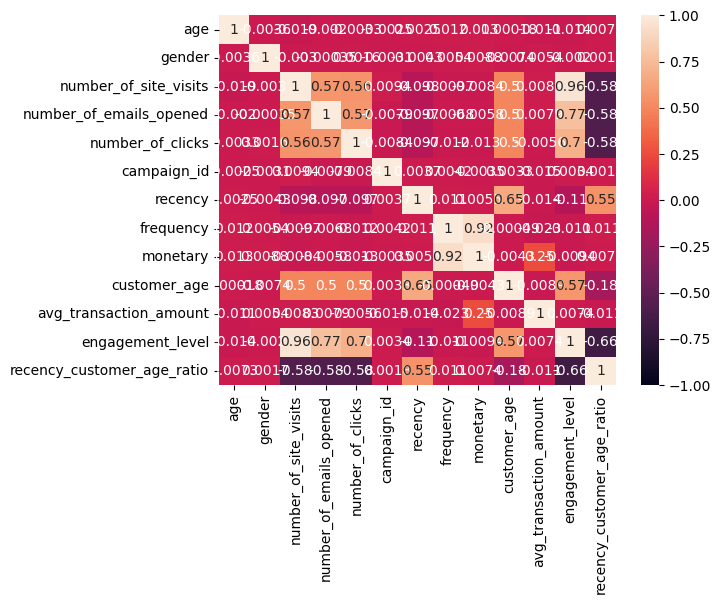

In [901]:
sns.heatmap(joint_data.iloc[:,:13].corr(), annot=True, vmin=-1, vmax=1)

In [902]:
# Evaluate the model
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print(mae_linear)
print(mse_linear)
print(r2_linear)

0.4783058616222665
0.24016789582760215
0.03928134147532358


In [903]:
# Create a DataFrame with actual vs predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_linear, 'Residual': y_test - y_pred_linear})

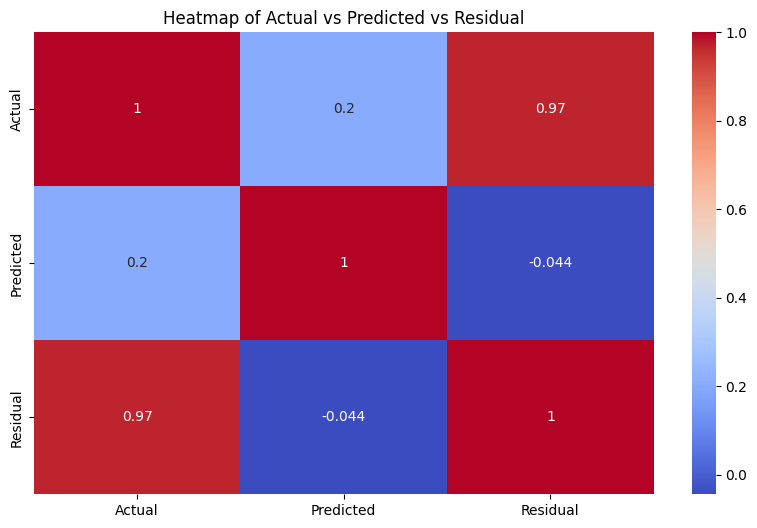

In [904]:
# Plot the residuals heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(results[['Actual', 'Predicted', 'Residual']].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Actual vs Predicted vs Residual')
plt.show()

In [905]:
# Train a KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [906]:
# Predict on the test set
y_pred_knn = knn_classifier.predict(X_test)


In [907]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)
conf_matrix = confusion_matrix(y_test, y_pred_knn)
print(f'KNN Classifier - Accuracy: {accuracy}')
print(f'KNN Classifier - Precision: {precision}')
print(f'KNN Classifier - Recall: {recall}')
print(f'KNN Classifier - F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

KNN Classifier - Accuracy: 0.7235
KNN Classifier - Precision: 0.6896551724137931
KNN Classifier - Recall: 0.8056394763343404
KNN Classifier - F1 Score: 0.7431490942870413
Confusion Matrix:
[[647 360]
 [193 800]]


In [908]:
# Predict the probabilities for the positive class
y_prob_knn = knn_classifier.predict_proba(X_test)[:, 1]

In [909]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob_knn)
roc_auc = auc(fpr, tpr)

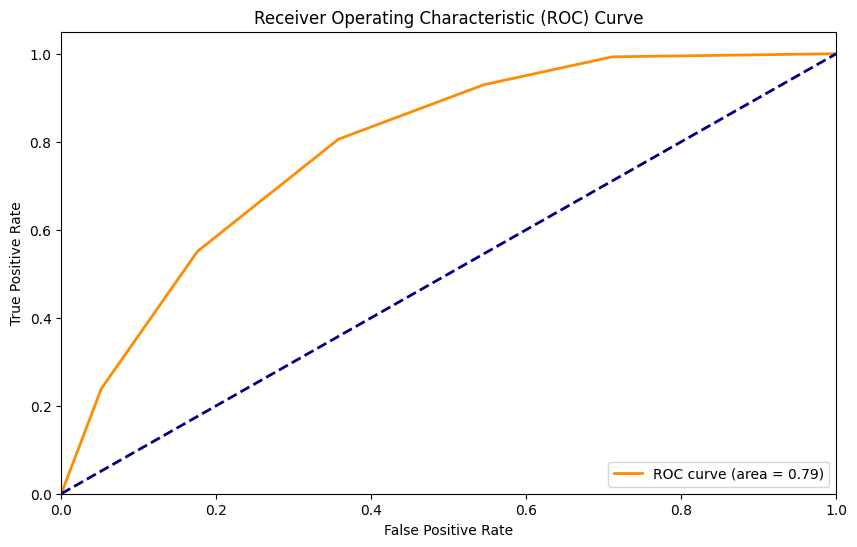

In [910]:
# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [911]:
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.64      0.70      1007
           1       0.69      0.81      0.74       993

    accuracy                           0.72      2000
   macro avg       0.73      0.72      0.72      2000
weighted avg       0.73      0.72      0.72      2000



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increas

Training ROC AUC: 0.9999917499747343
Test ROC AUC: 0.9999799990199519


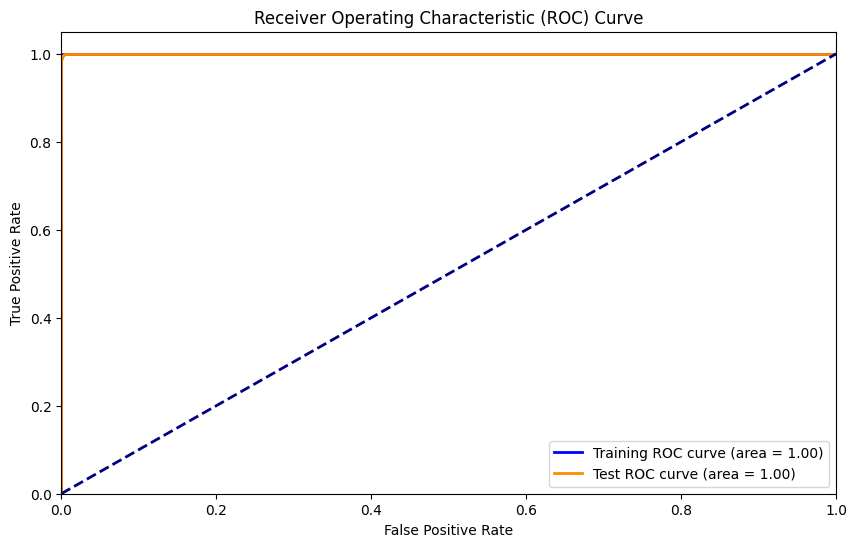

Logistic Regression Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1007
           1       1.00      1.00      1.00       993

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Cross-Validation AUC Scores: [0.999933 0.999946 0.999962 0.999962 0.999981]
Mean Cross-Validation AUC: 0.9999568


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [912]:
# Improving the logistic regression model
# Feature engineering - Create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Train the best logistic regression model
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred_logistic = best_model.predict(X_test)
y_prob_logistic = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
y_train_pred = best_model.predict(X_train)
y_train_prob = best_model.predict_proba(X_train)[:, 1]

train_fpr, train_tpr, _ = roc_curve(y_train, y_train_prob)
train_roc_auc = auc(train_fpr, train_tpr)

print(f'Training ROC AUC: {train_roc_auc}')

# Evaluate the model on test data
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]

test_fpr, test_tpr, _ = roc_curve(y_test, y_test_prob)
test_roc_auc = auc(test_fpr, test_tpr)

print(f'Test ROC AUC: {test_roc_auc}')

# Plot ROC curves for training and test sets
plt.figure(figsize=(10, 6))
plt.plot(train_fpr, train_tpr, color='blue', lw=2, label=f'Training ROC curve (area = {train_roc_auc:.2f})')
plt.plot(test_fpr, test_tpr, color='darkorange', lw=2, label=f'Test ROC curve (area = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print classification report for the test set
print("Logistic Regression Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Cross-validation AUC scores
cv_scores = cross_val_score(best_model, X_scaled, y, cv=5, scoring='roc_auc')
print(f'Cross-Validation AUC Scores: {cv_scores}')
print(f'Mean Cross-Validation AUC: {cv_scores.mean()}')

KNN Classifier - Accuracy: 0.699
KNN Classifier - Precision: 0.6725507502206531
KNN Classifier - Recall: 0.7673716012084593
KNN Classifier - F1 Score: 0.7168391345249294
Confusion Matrix:
[[636 371]
 [231 762]]


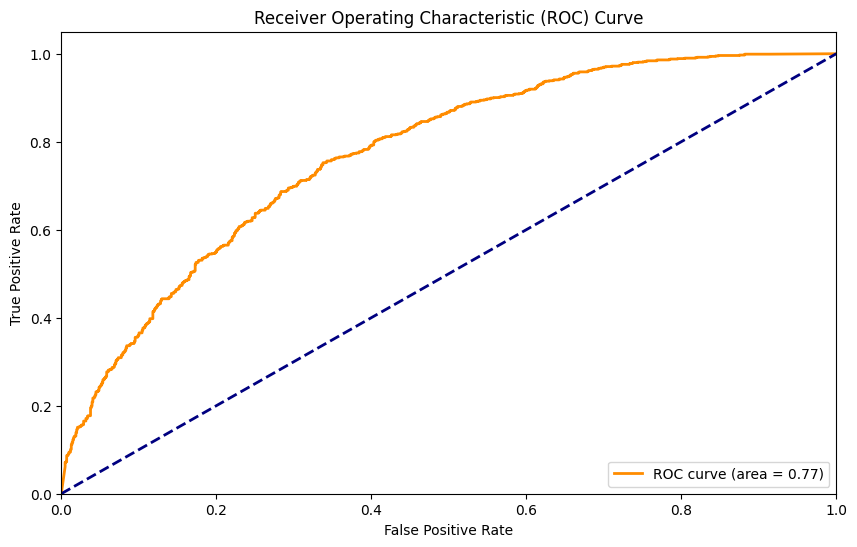

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.63      0.68      1007
           1       0.67      0.77      0.72       993

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000

Cross-Validation Accuracy Scores: [0.6955 0.717  0.7065 0.7025 0.7175]
Mean Cross-Validation Accuracy: 0.7078000000000001


In [913]:
# Improving the KNN model
# Feature engineering - Create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_knn = grid_search.best_estimator_

# Train the best KNN model
best_knn.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = best_knn.predict(X_test)
y_prob_knn = best_knn.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)
conf_matrix = confusion_matrix(y_test, y_pred_knn)

print(f'KNN Classifier - Accuracy: {accuracy}')
print(f'KNN Classifier - Precision: {precision}')
print(f'KNN Classifier - Recall: {recall}')
print(f'KNN Classifier - F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob_knn)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print classification report
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Cross-validation score
cv_scores = cross_val_score(best_knn, X_scaled, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')